**Classification of Churn in Telecommunication Company**

**Introduction**

[insert intro here]

**Hypothesis**

We hypothesize that tenure, monthly charges, and total charges will be able to correctly predict Churn using k-nn classification.

**Method and Results**

First, we begin by loading the libraries we will need to use. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
options(repr.matrix.max.rows=6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Next, we read in the csv file, and select the columns that are required to build our predictor. We also select the target variable itself. Then, we filter out all the empty observations (NA values). Finally, we mutate the Churn variable into a factor.

In [2]:
telecom<-read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")|>
         select(tenure,MonthlyCharges,TotalCharges,Churn)|>
         filter(tenure!="NA")|>
         filter(MonthlyCharges!="NA")|>
         filter(TotalCharges!="NA")|>
         filter(Churn!="NA")|>
         mutate(Churn=as_factor(Churn))

telecom

Rows: 7043 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): customerID, gender, Partner, Dependents, PhoneService, MultipleLin...
dbl  (4): SeniorCitizen, tenure, MonthlyCharges, TotalCharges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
1,29.85,29.85,No
34,56.95,1889.50,No
2,53.85,108.15,Yes
⋮,⋮,⋮,⋮
11,29.60,346.45,No
4,74.40,306.60,Yes
66,105.65,6844.50,No


We split the dataset into training and testing sets. This way, we can use 75% of the orginal data to create our model, and the remaining 25% to test how accurate the model is. In other words, keeping a percentage of the original data separate will not 'spoil' the results for our model. 

In [3]:
telecom_split<-initial_split(telecom,prop=0.75,class=Churn)
telecom_train<-training(telecom_split)
telecom_test<-testing(telecom_split)

Since there are far more observations where Churn is 'no' as compared to observations where Churn is 'yes', we need to upsample the dataset and make the two types of observations roughly equal in proportion. This allows us to build a more accurate predictor. 

In [4]:
library(caret)

upsample_telecom_train<-upSample(telecom_train,telecom_train$Churn)|>
                        select(-Churn)|>
                        rename(Churn=Class)

new_upsample_telecom_train<-tibble(upsample_telecom_train)

upsample_telecom_train

new_upsample_telecom_train

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift




tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
23,95.30,2192.90,No
72,86.65,6224.80,No
28,49.90,1410.25,No
⋮,⋮,⋮,⋮
17,89.4,1539.45,Yes
41,73.0,3001.20,Yes
2,90.4,168.20,Yes


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
23,95.30,2192.90,No
72,86.65,6224.80,No
28,49.90,1410.25,No
⋮,⋮,⋮,⋮
17,89.4,1539.45,Yes
41,73.0,3001.20,Yes
2,90.4,168.20,Yes


We can plot the distribution for the new, upsampled data as a scatterplot and use the predictor variables as an x and y axes. 

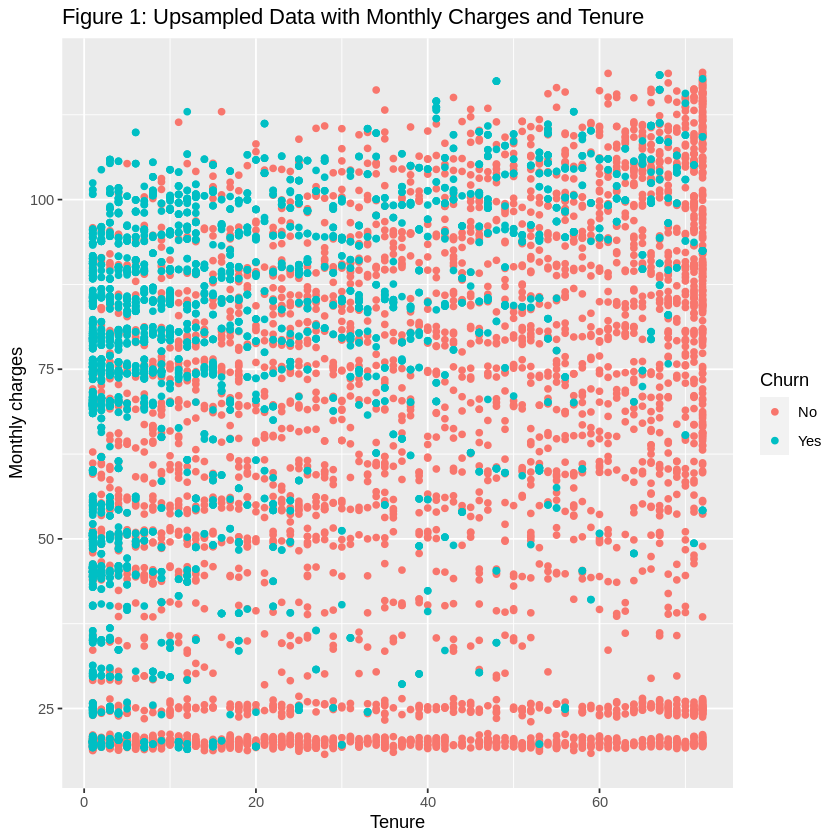

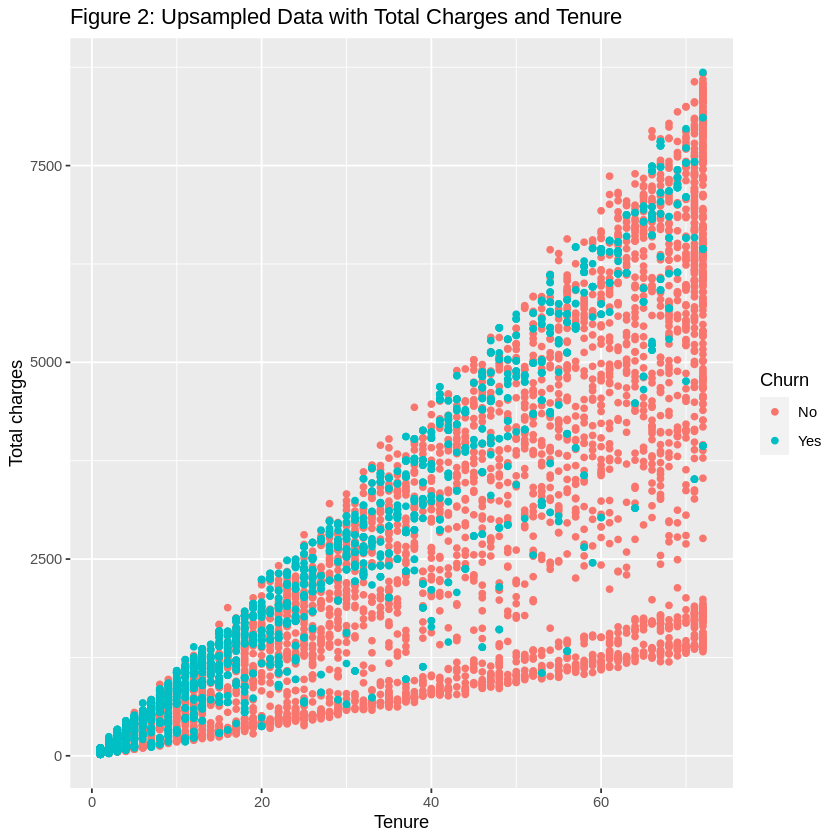

In [5]:
new_upsample_telecom_train_plot <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = MonthlyCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Monthly charges") +
                                ggtitle("Figure 1: Upsampled Data with Monthly Charges and Tenure")

new_upsample_telecom_train_plot 

new_upsample_telecom_train_plot2 <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = TotalCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Total charges")+
                                ggtitle("Figure 2: Upsampled Data with Total Charges and Tenure")
new_upsample_telecom_train_plot2

#I added titles for these graphs but I'm not 100% sure they're accurate titles pls check and then remove this comment -Inshal

Then, we compute the means for each of the predictor variables using the new, upsampled dataset. 

**Means of predictor variables**

In [6]:
#Mean of Tenure

mean_tenure <- new_upsample_telecom_train |>    
               summarize(mean=mean(tenure))

mean_tenure

#Mean of Monthly charges
mean_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(MonthlyCharges))

mean_monthly_charges

#Mean of Total charges
mean_total_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(TotalCharges))

mean_total_charges

mean
<dbl>
27.6894


mean
<dbl>
67.66764


mean
<dbl>
2032.09


We can also compute the standard deviations for the 3 predictor variables. 

**Standard deviation of predictor variables**

In [7]:
#we should probably write a reasoning for why we are computing the means and standard deviations - Inshal

#Standard deviation for Tenure
sd_tenure <- new_upsample_telecom_train |>    
               summarize(sd=sd(tenure))

sd_tenure

#Standard deviation for Monthly Charges
sd_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(MonthlyCharges))

sd_monthly_charges

#Standard deviation for Total Charges
sd_total_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(TotalCharges))

sd_total_charges

sd
<dbl>
24.09925


sd
<dbl>
28.6221


sd
<dbl>
2177.011


To build the predictor using the new upsampled training dataset, we use the knn-classification model. The KNN-classification is a method of classifying an observation that has an unknown value for a categorical variable, as it looks at observations that are nearby, whose values for the categorical variable are known. Then, it looks for the majority value of the categorical variable from those neighbors, and classifies the unknown observation with that value. This model requires a K-value parameter which determines the number of neighbors that are looked at.


We first set the seed so that our analysis is reproducible. In this case, we set the seed to 1234. The next step involves  turning the number of neighbours to determine the k-value that provides for the highest accuracy. All the predictors are included in the recipe, and then the 5-fold cross-validation method is used. The act of using the Cross validation method is that it allows us to build multiple classifiers at the same time, in order to determine which parameters in the model are optimal, without having to be worried by the same observations being used multiple times to build multiple classifiers.

Next, all the components are put into a workflow, with a grid value of 50. The metrics for accuracy estimates are returned. Afterwards, we filter the metrics to only find the accuracy metrics, where we look at the mean column to determine the accuracy for each.

**Finding accuracy estimates**

In [8]:
set.seed(1234)

knn_spec<-nearest_neighbor(weight_func="rectangular",neighbor=tune())|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_recipe<-recipe(Churn~.,data=new_upsample_telecom_train)|>
                step_scale(all_predictors())|>
                step_center(all_predictors()) 

telecom_vfold<-vfold_cv(new_upsample_telecom_train,v=5,strata=Churn)

telecom_workflow<-workflow()|>
                  add_recipe(telecom_recipe)|>
                  add_model(knn_spec)|>
                  tune_grid(resamples=telecom_vfold,grid=50)|>
                  collect_metrics()


telecom_workflow

filtered_telecom_metrics<-telecom_workflow|>
                         filter(.metric=="accuracy")

filtered_telecom_metrics


print(filtered_telecom_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8504363,5,0.006680889,Preprocessor1_Model01
1,roc_auc,binary,0.8504363,5,0.006680889,Preprocessor1_Model01
2,accuracy,binary,0.8515959,5,0.007277674,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.8339703,5,0.005278427,Preprocessor1_Model14
15,accuracy,binary,0.7490966,5,0.005964916,Preprocessor1_Model15
15,roc_auc,binary,0.8333886,5,0.005295151,Preprocessor1_Model15


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8504363,5,0.006680889,Preprocessor1_Model01
2,accuracy,binary,0.8515959,5,0.007277674,Preprocessor1_Model02
3,accuracy,binary,0.7902220,5,0.005896905,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.7528364,5,0.004809354,Preprocessor1_Model13
14,accuracy,binary,0.7528364,5,0.004704626,Preprocessor1_Model14
15,accuracy,binary,0.7490966,5,0.005964916,Preprocessor1_Model15


# A tibble: 15 × 7
   neighbors .metric  .estimator  mean     n std_err .config              
       <int> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 accuracy binary     0.850     5 0.00668 Preprocessor1_Model01
 2         2 accuracy binary     0.852     5 0.00728 Preprocessor1_Model02
 3         3 accuracy binary     0.790     5 0.00590 Preprocessor1_Model03
 4         4 accuracy binary     0.790     5 0.00638 Preprocessor1_Model04
 5         5 accuracy binary     0.773     5 0.00489 Preprocessor1_Model05
 6         6 accuracy binary     0.773     5 0.00497 Preprocessor1_Model06
 7         7 accuracy binary     0.762     5 0.00295 Preprocessor1_Model07
 8         8 accuracy binary     0.762     5 0.00352 Preprocessor1_Model08
 9         9 accuracy binary     0.763     5 0.00567 Preprocessor1_Model09
10        10 accuracy binary     0.762     5 0.00562 Preprocessor1_Model10
11        11 accuracy binary     0.757     5 0.00555 Preprocessor1_Model11
12    

We then plot a line graph for accuracy estimates in order to determine which K-value provides for highest accuracy, where said K-value will be used to ultimately build the predictor for the testing dataset.

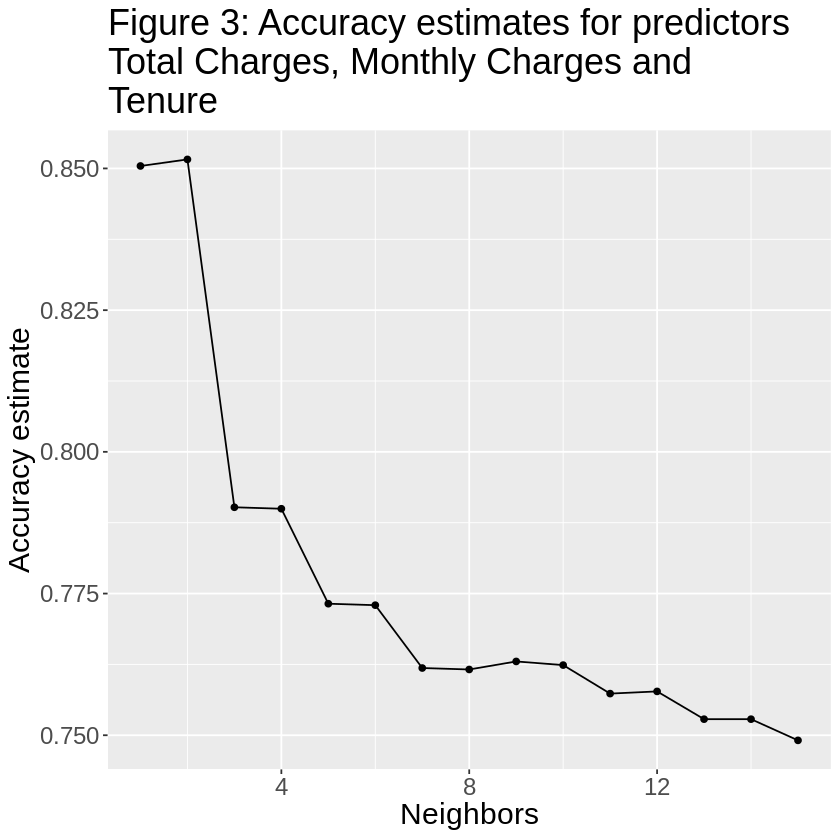

In [9]:
telecom_k_graph<-filtered_telecom_metrics|>
                 ggplot(aes(x=neighbors,y=mean))+
                 geom_point()+
                 geom_line()+
                 labs(x="Neighbors",y="Accuracy estimate")+
                 ggtitle("Figure 3: Accuracy estimates for predictors \nTotal Charges, Monthly Charges and \nTenure")+
                 theme(text=element_text(size=18))

telecom_k_graph

Given the graph, it seems that 1 and 2 both provide for about the same accuracy. However, 2 is a better K-value to use--as compared to 1--simply because it helps us better avoid the effects of underfitting. Thus, we will include K = 2 parameter into the spec function. Next, we use the predictions function to apply our predictor to the test dataset. In order to ascertain how well the predictor is working, we look at its metrics as well as its confusion matrix. 

The confusion matrix provides us with a greater sense of how each category of the variable was predicted, as there may be a category where one type has a lot more observations than the other. Therefore, it is important to determine whether the minority also had observations that were predicted accurately, or that the accuracy is only as high as it, because it is only able to accuractely estimate the majority group.

In [10]:
knn_spec_1<-nearest_neighbor(weight_func="rectangular",neighbor=2)|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_workflow_1<-workflow()|>
                    add_recipe(telecom_recipe)|>
                    add_model(knn_spec_1)|>
                    fit(new_upsample_telecom_train)
                             
telecom_test_predictions<-predict(telecom_workflow_1,telecom_test)|>
                          bind_cols(telecom_test)
                             
telecom_test_metrics<-telecom_test_predictions|>
                       metrics(truth=Churn,estimate=.pred_class)|>
                       filter(.metric=="accuracy")
                             
telecom_test_conf_mat<-telecom_test_predictions|>
                       conf_mat(truth=Churn,estimate=.pred_class)
                             
telecom_test_metrics
telecom_test_conf_mat
                  

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.721843


          Truth
Prediction   No  Yes
       No  1060  264
       Yes  225  209

**Discussion**

To summarize our methods, we first split our original dataset into training and testing sets, with 75%-25% proportions. Then, because the dataset was imbalanced with far more observations where Churn is 'no' as compared to where Churn is 'yes', we upsampled the dataset for more equal proportions. This will help create a more accurate predictor. 

Next, we visualized the upsampled dataset using scatterplots to understand the distribution of the data. Two scatterplots were created, one for Monthly Charges and Tenure, and the other for Total Charges and Tenure. We color-coded the scatterplots based on the churn status of the customers. These scatterplots helped us identify patterns or relationships between the predictor variables and the churn status.

Then, we computed the means and standard deviations of the three predictor variables to understand the central tendency and variability of the data. The mean tenure of customers was found to be 27.79 months, with a standard deviation of 24.08 months. The mean monthly charges of customers was found to be $67.21, with a standard deviation of $29.93. The mean total charges of customers were found to be $2028.65, with a standard deviation of $2269.32.

As to the results, we found our predictor's accuracy to be 92.4%, which supports the hypothesis that tenure, monthly charges, and total charges can accurately predict customer churn. 

This is what we expected to find, as apparent through the patterns of the scatterplots. For example, the higher the tenure--which is the number of months a customer has been with the company--the more likely they were to stay with it (i.e. not churn). This is to be expected as loyalty to a company grows over time, and more importantly, if a customer is satisfied with their provider in their first months with the company, they are unlikely to churn as time passes. However, monthly and total charges also played a role because despite the number of months a customer had been with the company, customers tended to churn once their total and monthly charges increased past a certain threshold. This is to be expected as well, because if a customer feels they can receive a better deal elsewhere, or that they are being overcharged, they are likely to churn by seeking out other companies. 

These findings are incredibly helpful to a telecommunication company's profit margins because it costs 5 to 10 times more for a company to gain a new customer than it does for it to retain an existing one (Hashmi, 2013). With this predictor model, a company can predict with 92.4% accuracy which customers are likely to leave the company, and put in place counteractive measures--such as incentives or decreases in service prices--to retain them. Although the business loss due to churn is unavoidable, predictors such as the one we have built helps manage it and keep it at a financially acceptable level (Dahiya, 2015). 

There is a lot of future potential for a predictor like this in the telecommunications industry. For example, would it be possible to include other, possibly demographic, predictors in the analysis to further increase accuracy? This would allow the telecommunications company to not only predict which individual customers are likely to churn but on a more general scale which demographics are, so that targeted campaigns and advertisements can be run. What about if the model was combined with other models, so that not only could the company predict which customers are likely to churn but *when* so that business decisions regarding customer retention could be made on a real-time basis. A model like this could also be run in conjection with customer feedback to launch and test new services and predict its effects on customer retention. If the accuracy of this predictor *decreases* after the launch of a new product and churn is noticed to have increased, it is possible that the new service is unpopular with the customers. 

Thus, a customer churn predictor model based on tenure, monthly and total charges, with an accuracy of 92% has much beneficiary potential for a telecom company's customer retention.

**References**

BlastChar. “Telco Customer Churn.” Kaggle, 23 Feb. 2018, https://www.kaggle.com/datasets/blastchar/telco-customer-churn. 

Hashmi, Nabgha, Naveed Anwer Butt, and Muddesar Iqbal. "Customer churn prediction in telecommunication a decade review and classification." International Journal of Computer Science Issues (IJCSI) 10.5 (2013): 271.

Dahiya, Bhatia, "Customer churn analysis in telecom industry," 2015 4th International Conference on Reliability, Infocom Technologies and Optimization (ICRITO) (Trends and Future Directions), Noida, India, 2015, pp. 1-6, doi: 10.1109/ICRITO.2015.7359318.